In [30]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

import geopandas as gpd
from shapely.geometry import Point

from IPython.display import HTML

pd.options.mode.copy_on_write = True

### Intro

Have you ever met a Turkish person who supports Tottenham FC? This map might be your answer. 🗺⚽

Using publicly available census data, I’ve mapped the percentage of people in London who speak Turkish as their main language. Tottenham is at the top the list, making it the area with the highest concentration of Turkish speakers in London.

It’s no surprise then that the local football team, Tottenham Hotspur, might have some unexpected Turkish fans among their supporters considering how much Turks love football!

Maps like these highlight how data analysis can uncover fascinating cultural insights. Whether you’re looking to locate the next big fan group for your sports team, or simply curious about community distributions in urban areas, spatial analysis brings valuable stories to light.

### The percentage of people speaking each language as a main language in 2021

In [33]:
lan = pd.read_excel('data/3-other_languages.xlsx')

In [34]:
lan.head()

Area code             Area name  \
0  E06000001            Hartlepool   
1  E06000002         Middlesbrough   
2  E06000003  Redcar and Cleveland   
3  E06000004      Stockton-on-Tees   
4  E06000005            Darlington   

   English (English or Welsh in Wales)\n(number)  \
0                                          87544   
1                                         128306   
2                                         131197   
3                                         184786   
4                                         100200   

   Welsh or Cymraeg (in England only)\n(number)  \
0                                             4   
1                                             4   
2                                             5   
3                                             5   
4                                             0   

   Other UK language: Gaelic (Irish)\n(number)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Other UK language: Gaelic (Scottish)\n(number)  \
0                                               0   
1                                               1   
2                                               1   
3                                               1   
4                                               1   

   Other UK language: Manx Gaelic\n(number)  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Other UK language: Gaelic (Not otherwise specified)\n(number)  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  1               
4                                                  0               

   Other UK language: Cornish\n(number)  Other UK language: Scots\n(number)  \
0                                     0                                   3   
1                                     0                                   0   
2                                     0                                   3   
3                                     1                                   3   
4                                     0                                   1   

   ...  African language: Lingala\n(percent)  \
0  ...                                   0.0   
1  ...                                   0.0   
2  ...                                   0.0   
3  ...                                   0.0   
4  ...                                   0.0   

   African language: Shona\n(percent)  African language: Afrikaans\n(percent)  \
0                                0.01                                    0.01   
1                                0.01                                    0.00   
2                                0.00                                    0.00   
3                                0.03                                    0.01   
4                                0.00                                    0.01   

   African language: Any other Nigerian language\n(percent)  \
0                                               0.00          
1                                               0.01          
2                                               0.00          
3                                               0.00          
4                                               0.00          

   African language: Any other West African language\n(percent)  \
0                                               0.01              
1                                               0.01              
2          

### The percentage of people speaking Turkish as a main language in 2021

In [36]:
tr = lan.filter(regex='(Turk)|(Area)')

In [37]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area code          331 non-null    object 
 1   Area name          331 non-null    object 
 2   Turkish
(number)   331 non-null    int64  
 3   Turkish
(percent)  331 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.5+ KB


In [38]:
tr['log_pct'] = np.log1p(tr['Turkish\n(percent)'])

tr

Area code             Area name  Turkish\n(number)  Turkish\n(percent)  \
0    E06000001            Hartlepool                 34                0.04   
1    E06000002         Middlesbrough                 39                0.03   
2    E06000003  Redcar and Cleveland                 13                0.01   
3    E06000004      Stockton-on-Tees                 41                0.02   
4    E06000005            Darlington                 46                0.04   
..         ...                   ...                ...                 ...   
326  W06000020               Torfaen                 24                0.03   
327  W06000021         Monmouthshire                 29                0.03   
328  W06000022               Newport                256                0.17   
329  W06000023                 Powys                 65                0.05   
330  W06000024        Merthyr Tydfil                 41                0.07   

      log_pct  
0    0.039221  
1    0.029559  
2    0.009950  
3    0.019803  
4    0.039221  
..        ...  
326  0.029559  
327  0.029559  
328  0.157004  
329  0.048790  
330  0.067659  

[331 rows x 5 columns]

## Choropleth Map

In [40]:
# Local Authority Districts Boundaries UK BUC (2021)

# Fetch the GeoJSON data from web
response_boundary = requests.get(
    #"https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LAD_Dec_2021_GB_BFC_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2021_UK_BUC_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
) # requests is the library, get() sends an HTTP GET request to the specified URL. It retrieves data from the server and returns a Response object. 

# Convert the JSON response object to a dictionary
# This dictionary contains a featurecollection
# FeatureCollection = An object defining a layer of features whose geometry and attributes will be stored directly within the web map
dict_boundary = response_boundary.json() 

# Convert the data to a GeoDataFrame
gdf_boundary = gpd.GeoDataFrame.from_features(dict_boundary['features'], crs="EPSG:4326")


In [41]:
######### JOINED

gdf_tr = tr.merge(gdf_boundary, left_on='Area code', right_on='LAD21CD')

gdf_tr = gpd.GeoDataFrame(gdf_tr, geometry=gdf_tr.geometry)


In [ ]:
import plotly.express as px
import pandas as pd

gdf_tr['Turkish_percent'] = gdf_tr['Turkish\n(percent)']  # Adjust column name if necessary

# Define bins and labels for the percentages
bins = [0.00, 0.25, 0.77, 1.75, 3.75, 5.91]
labels = ['0.00 - 0.25 %', '0.26 - 0.77 %', '0.78 - 1.75 %', '1.76 - 3.75 %', '3.76 - 5.91 %']

# Create a new column for the categorized data
gdf_tr['Turkish_percent_category'] = pd.cut(
    gdf_tr['Turkish_percent'], bins=bins, labels=labels, include_lowest=True
)

# Define a discrete color scale for the categories
color_scale = ['#eed0bc', '#ffa9a6', '#cc5a78', '#491717','#811212']

# Locations and their coordinates (Longitude, Latitude)
locations = {
    "Enfield": [-0.081, 51.652],
    "Haringey": [-0.069, 51.597],
    #"Wood Green": [-0.110, 51.596],
    #"Dalston": [-0.075, 51.548],
    "Hackney": [-0.053, 51.553],
    "Tottenham FC": [-0.0722, 51.6035]
}

# Create the map
fig = px.choropleth_mapbox(
    gdf_tr,
    geojson=gdf_tr.geometry.__geo_interface__,
    locations=gdf_tr.index,
    color="Turkish_percent_category",
    color_discrete_sequence=color_scale,
    opacity=1,
    width=1000, height=750
).update_layout(
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -0.05, "lat": 51.53},
        "zoom": 9
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

# Add labels as scattermapbox overlay
fig.add_scattermapbox(
    mode="markers+text",
    lon=[coord[0] for coord in locations.values()],
    lat=[coord[1] for coord in locations.values()],
    text=list(locations.keys()),
    marker=dict(size=9, color="white"),
    textfont=dict(size=16, color="white", weight = 'bold'),
    textposition="top center"  # Position the text above the marker
)

fig.show()


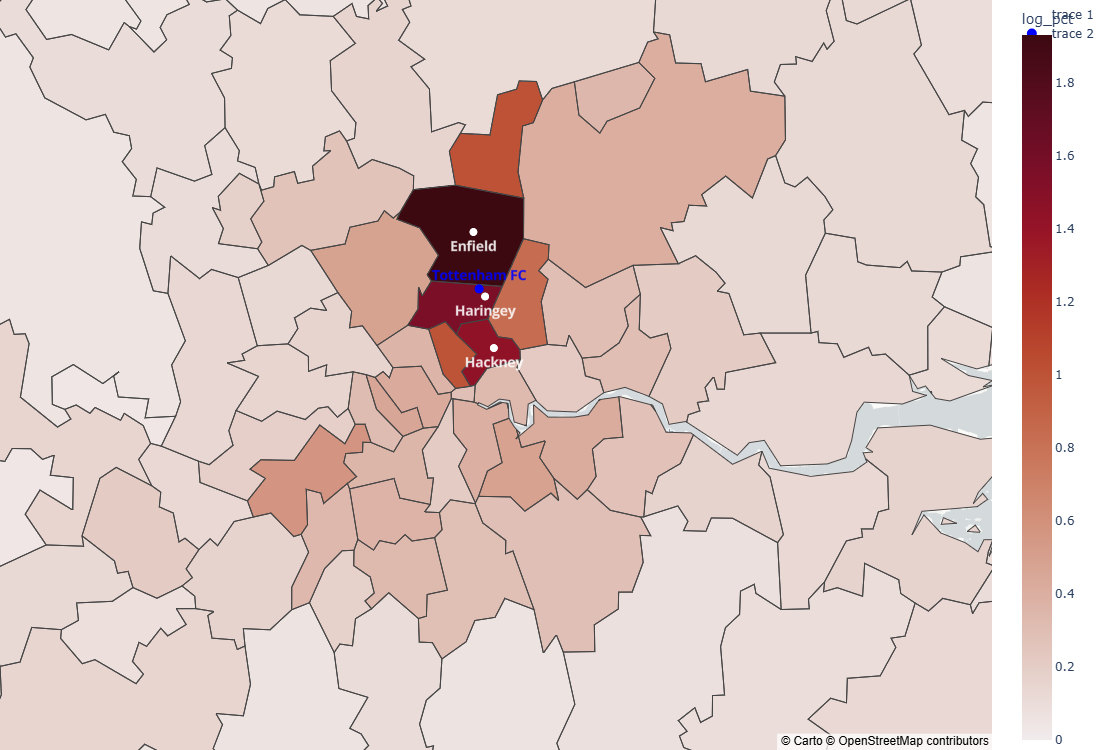

In [237]:

# Locations and their coordinates (Longitude, Latitude)
locations = {
    "Enfield": [-0.081, 51.652],
    "Haringey": [-0.065, 51.597],
    #"Wood Green": [-0.110, 51.596],
    #"Dalston": [-0.075, 51.548],
    "Hackney": [-0.053, 51.553]
}

hackney = {
    "name": "Hackney",
    "coordinates": [-0.053, 51.553],  # Approximate location for Tottenham Hotspur Stadium
    "color": "white"  # Unique color for the marker
}

# Tottenham FC coordinates
tottenham_fc = {
    "name": "Tottenham FC",
    "coordinates": [-0.0732, 51.6035],  # Approximate location for Tottenham Hotspur Stadium
    "color": "blue"  # Unique color for the marker
}

# Create the map
fig = px.choropleth_mapbox(
    gdf_tr,
    geojson=gdf_tr.geometry.__geo_interface__,
    locations=gdf_tr.index,
    color="log_pct",
    color_continuous_scale='amp', #''Reds', #px.colors.sequential.Cividis_r, #px.colors.diverging.BrBG, 
    opacity=1,
    width=1000, height=750
).update_layout(
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -0.05, "lat": 51.53},
        "zoom": 9
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

# Add labels as scattermapbox overlay
fig.add_scattermapbox(
    mode="markers+text",
    lon=[coord[0] for coord in locations.values()],
    lat=[coord[1] for coord in locations.values()],
    text=list(locations.keys()),
    marker=dict(size=9, color="white"),
    textfont=dict(size=16, color="white", weight = 'bold'),
    textposition="bottom center"  # Position the text above the marker
)

fig.add_scattermapbox(
    mode="markers+text",
    lon=[tottenham_fc["coordinates"][0]],
    lat=[tottenham_fc["coordinates"][1]],
    text=[tottenham_fc["name"]],
    marker=dict(size=10, color=tottenham_fc["color"]),
    textfont=dict(size=16, color=tottenham_fc["color"], weight='bold'),
    textposition="top center"  # Position the text below and to the right of the marker
)


fig.show()


### Red

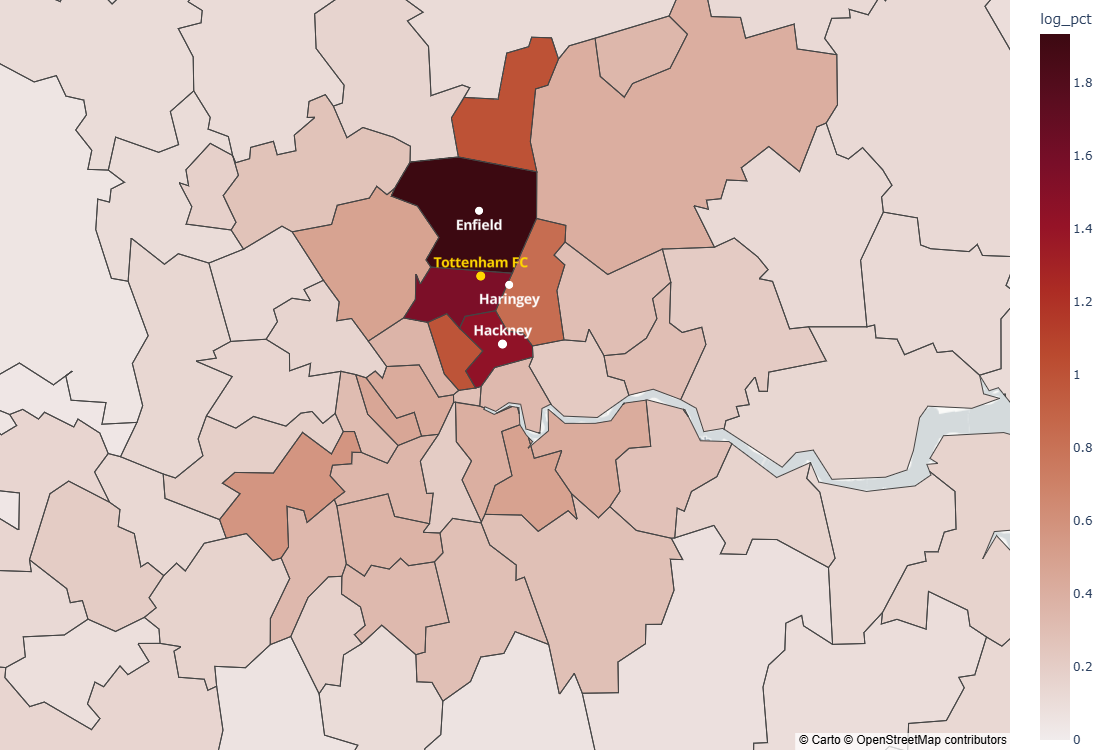

In [225]:
# Locations and their coordinates (Longitude, Latitude)
locations = {
    "Enfield": [-0.081, 51.652],
    "Haringey": [-0.045, 51.597],
    #"Wood Green": [-0.110, 51.596],
    #"Dalston": [-0.075, 51.548],
    #"Hackney": [-0.053, 51.553]
}

hackney = {
    "name": "Hackney",
    "coordinates": [-0.053, 51.553],  
    "color": "white" 
}

# Tottenham FC coordinates
tottenham_fc = {
    "name": "Tottenham FC",
    "coordinates": [-0.079, 51.6035], 
    "color": "#FFD700"  # Unique color for the marker
}

# Create the map with the custom color scale
fig = px.choropleth_mapbox(
    gdf_tr,
    geojson=gdf_tr.geometry.__geo_interface__,
    locations=gdf_tr.index,
    color="log_pct",
    color_continuous_scale="amp", 
    opacity=1,
    width=1000, height=750
).update_layout(
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -0.05, "lat": 51.53},
        "zoom": 9.20
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

# Add labels as scattermapbox overlay
fig.add_scattermapbox(
    mode="markers+text",
    lon=[coord[0] for coord in locations.values()],
    lat=[coord[1] for coord in locations.values()],
    text=list(locations.keys()),
    marker=dict(size=9, color="white"),
    textfont=dict(size=14, color="white", weight='bold'),
    textposition="bottom center",  # Position the text below the marker
    showlegend=False  # Remove this layer from the legend
)

fig.add_scattermapbox(
    mode="markers+text",
    lon=[hackney["coordinates"][0]],
    lat=[hackney["coordinates"][1]],
    text=[hackney["name"]],
    marker=dict(size=9, color=hackney["color"]),
    textfont=dict(size=14, color=hackney["color"], weight='bold'),
    textposition="top center",  # Position the text above the marker
    showlegend=False  # Remove this layer from the legend
)

fig.add_scattermapbox(
    mode="markers+text",
    lon=[tottenham_fc["coordinates"][0]],
    lat=[tottenham_fc["coordinates"][1]],
    text=[tottenham_fc["name"]],
    marker=dict(size=9, 
                color=tottenham_fc["color"], 
                symbol="circle"),  # Change to "cross" shape
    textfont=dict(size=14, color=tottenham_fc["color"], weight='bold'),
    textposition="top center",
    showlegend=False  # Remove this layer from the legend
)

fig.show()



### Tottenham Blue

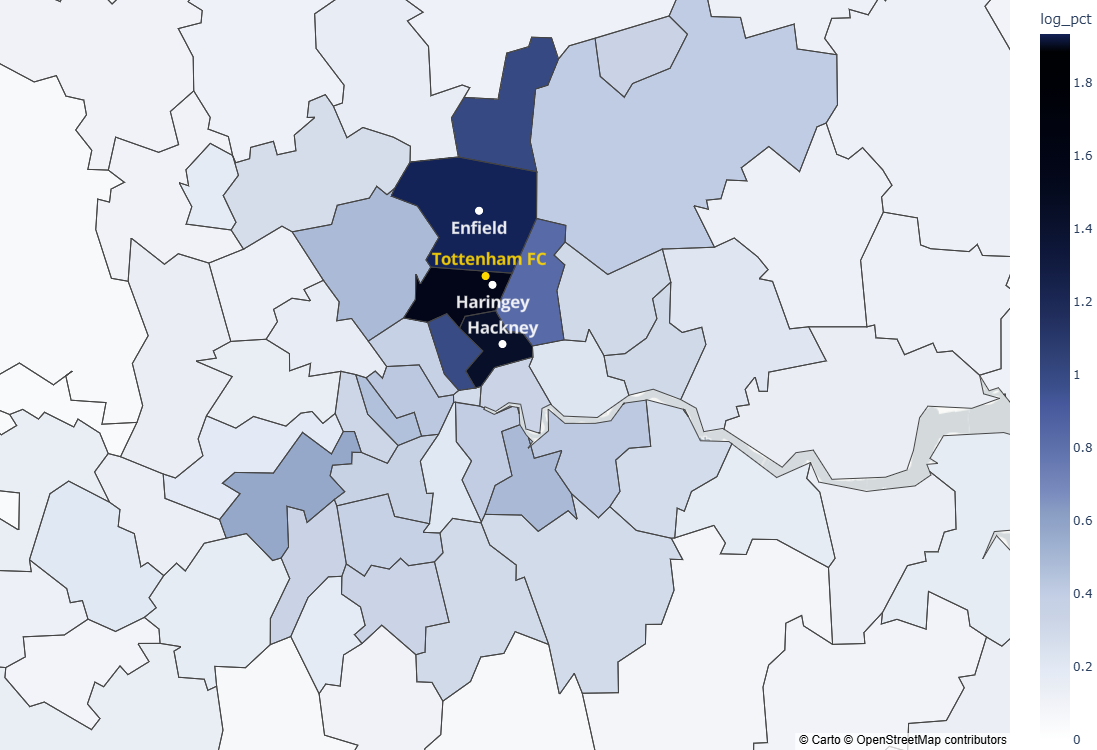

In [307]:
# Locations and their coordinates (Longitude, Latitude)
locations = {
    "Enfield": [-0.081, 51.652],
    "Haringey": [-0.065, 51.597],
    #"Wood Green": [-0.110, 51.596],
    #"Dalston": [-0.075, 51.548],
    #"Hackney": [-0.053, 51.553]
}


hackney = {
    "name": "Hackney",
    "coordinates": [-0.053, 51.553],  
    "color": "white" 
}

# Tottenham FC coordinates
tottenham_fc = {
    "name": "Tottenham FC",
    "coordinates": [-0.0732, 51.6035], 
    "color": "#FFD700"  # Unique color for the marker
}

# Create the map with the custom color scale
fig = px.choropleth_mapbox(
    gdf_tr,
    geojson=gdf_tr.geometry.__geo_interface__,
    locations=gdf_tr.index,
    color="log_pct",
    color_continuous_scale=[
    (0.0, "white"),          # Starting from white
    (0.025, "#F8F9FB"),      # Almost white
    (0.05, "#F1F3F8"),       
    (0.075, "#E9EDF4"),      
    (0.1, "#E3EAF5"),        # Very light version of the main color
    (0.125, "#DAE2EF"),      
    (0.15, "#D1DAE9"),       
    (0.175, "#C9D3E5"),      
    (0.2, "#C5D0E6"),        # Lighter blend
    (0.225, "#B8C6DE"),      
    (0.25, "#ABBBD7"),       
    (0.275, "#9FB1D0"),      
    (0.3, "#93A6C9"),        
    (0.325, "#889CC3"),      
    (0.35, "#7A8BBE"),       # Mid-tone blend
    (0.375, "#6F81B6"),      
    (0.4, "#6476AF"),        
    (0.425, "#5A6CA8"),      
    (0.45, "#5062A2"),       
    (0.475, "#47599C"),      
    (0.5, "#3B4F8C"),        # Darker mid-tone
    (0.525, "#35477F"),      
    (0.55, "#2E3F73"),       
    (0.575, "#273668"),      
    (0.6, "#212E5D"),        
    (0.625, "#1B2753"),      
    (0.65, "#16214A"),       
    (0.675, "#111B40"),      
    (0.7, "#0D1637"),        
    (0.725, "#0A122E"),      
    (0.75, "#070E26"),       
    (0.775, "#050B1F"),      
    (0.8, "#030719"),        # Approaching dark
    (0.825, "#020515"),      
    (0.85, "#010411"),       
    (0.875, "#01030E"),      
    (0.9, "#00020A"),        
    (0.925, "#000107"),      
    (0.95, "#000105"),       
    (0.975, "#000103"),      
    (1.0, "#132257")         # Main darkest color
], 
    opacity=1,
    width=1000, height=750
).update_layout(
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -0.05, "lat": 51.53},
        "zoom": 9.20
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

# Add labels as scattermapbox overlay
fig.add_scattermapbox(
    mode="markers+text",
    lon=[coord[0] for coord in locations.values()],
    lat=[coord[1] for coord in locations.values()],
    text=list(locations.keys()),
    marker=dict(size=9, color="white"),
    textfont=dict(size=17, color="white", weight='bold'),
    textposition="bottom center",  # Position the text below the marker
    showlegend=False  # Remove this layer from the legend
)

fig.add_scattermapbox(
    mode="markers+text",
    lon=[hackney["coordinates"][0]],
    lat=[hackney["coordinates"][1]],
    text=[hackney["name"]],
    marker=dict(size=9, color=hackney["color"]),
    textfont=dict(size=17, color=hackney["color"], weight='bold'),
    textposition="top center",  # Position the text above the marker
    showlegend=False  # Remove this layer from the legend
)

fig.add_scattermapbox(
    mode="markers",
    lon=[tottenham_fc["coordinates"][0]],  
    lat=[tottenham_fc["coordinates"][1]], 
    marker=dict(size=9, 
                color=tottenham_fc["color"], 
                symbol="circle"
               ),  
    showlegend=False  # Remove this layer from the legend
)

fig.add_scattermapbox(
    mode="text",
    lon=[tottenham_fc["coordinates"][0], -0.069],  # Marker lon + Text lon
    lat=[tottenham_fc["coordinates"][1], 51.6165],  # Marker lat + Text lat
    text=["", tottenham_fc["name"]],  # Add an empty string for the marker to offset the text
    textfont=dict(size=17, color=tottenham_fc["color"], weight='bold'),
    showlegend=False  # Remove this layer from the legend
)

fig.show()



#### textposition

"top left"

"top center"

"top right"

"middle left"

"middle center"

"middle right"

"bottom left"

"bottom center"

"bottom right"


#### Additional symbol Options

"circle"

"square"

"diamond"

"triangle-up"

"triangle-down"

"x"

"star"